In [1]:
import glob
import os
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, MaxPooling2D, Conv2D, Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
fear = []
happy = []
angry = []
neutral = []

In [3]:
tf.config.list_physical_devices('GPU')

AttributeError: module 'tensorflow_core._api.v2.config' has no attribute 'list_physical_devices'

In [32]:
def label_creator():
    files = glob.glob('emotion_images/train/*/*')
    len(files)
    files[0:10]
    
    emotions = []
    filename = []
    for i in files:
        path = i.replace('\\', '/')
        emotions.append(path.split('/')[2])
        filename.append(path.split('/')[3])

    outfile = list(zip(files, filename, emotions))

    df = pd.DataFrame(outfile, columns = ['path', 'filename', 'emotion'])
    df['emotion_value'] = df['emotion']
    #dummies = pd.get_dummies(df, columns = ['emotion'])
    #return dummies
    return df




In [33]:
df = label_creator()
#dummies

In [34]:
df
df['emotion_value'].value_counts()

happy       7215
neutral     4965
sad         4830
fear        4097
angry       3995
surprise    3171
disgust      436
Name: emotion_value, dtype: int64

In [35]:
df

,path,filename,emotion,emotion_value
0,emotion_images/train/happy/Training_50449107.jpg,Training_50449107.jpg,happy,happy
1,emotion_images/train/happy/Training_70433018.jpg,Training_70433018.jpg,happy,happy
2,emotion_images/train/happy/Training_85610005.jpg,Training_85610005.jpg,happy,happy
3,emotion_images/train/happy/Training_4460748.jpg,Training_4460748.jpg,happy,happy
4,emotion_images/train/happy/Training_6312930.jpg,Training_6312930.jpg,happy,happy
...,...,...,...,...
28704,emotion_images/train/disgust/Training_94788538...,Training_94788538.jpg,disgust,disgust
28705,emotion_images/train/disgust/Training_81049148...,Training_81049148.jpg,disgust,disgust
28706,emotion_images/train/disgust/Training_28365203...,Training_28365203.jpg,disgust,disgust
28707,emotion_images/train/disgust/Training_39197750...,Training_39197750.jpg,disgust,disgust


In [36]:
#select only neutral and happy to test classification
cropped = df[df['emotion_value'] == 'neutral']
cropped1 = df[df['emotion_value'] == 'sad']
cropped = cropped.append(cropped1)
cropped['emotion_value'].value_counts()
df = cropped
df

,path,filename,emotion,emotion_value
19313,emotion_images/train/neutral/Training_27707774...,Training_27707774.jpg,neutral,neutral
19314,emotion_images/train/neutral/Training_22310147...,Training_22310147.jpg,neutral,neutral
19315,emotion_images/train/neutral/Training_64310277...,Training_64310277.jpg,neutral,neutral
19316,emotion_images/train/neutral/Training_7510099.jpg,Training_7510099.jpg,neutral,neutral
19317,emotion_images/train/neutral/Training_27349834...,Training_27349834.jpg,neutral,neutral
...,...,...,...,...
12040,emotion_images/train/sad/Training_34443905.jpg,Training_34443905.jpg,sad,sad
12041,emotion_images/train/sad/Training_39739035.jpg,Training_39739035.jpg,sad,sad
12042,emotion_images/train/sad/Training_30529781.jpg,Training_30529781.jpg,sad,sad
12043,emotion_images/train/sad/Training_62983628.jpg,Training_62983628.jpg,sad,sad


In [39]:
#get dummies for the two classes
df['sad'] = pd.get_dummies(df['emotion_value'], drop_first=True)
df

,path,filename,emotion,emotion_value,sad
19313,emotion_images/train/neutral/Training_27707774...,Training_27707774.jpg,neutral,neutral,0
19314,emotion_images/train/neutral/Training_22310147...,Training_22310147.jpg,neutral,neutral,0
19315,emotion_images/train/neutral/Training_64310277...,Training_64310277.jpg,neutral,neutral,0
19316,emotion_images/train/neutral/Training_7510099.jpg,Training_7510099.jpg,neutral,neutral,0
19317,emotion_images/train/neutral/Training_27349834...,Training_27349834.jpg,neutral,neutral,0
...,...,...,...,...,...
12040,emotion_images/train/sad/Training_34443905.jpg,Training_34443905.jpg,sad,sad,1
12041,emotion_images/train/sad/Training_39739035.jpg,Training_39739035.jpg,sad,sad,1
12042,emotion_images/train/sad/Training_30529781.jpg,Training_30529781.jpg,sad,sad,1
12043,emotion_images/train/sad/Training_62983628.jpg,Training_62983628.jpg,sad,sad,1


In [40]:
df = df.sample(frac = 1, axis = 0, ignore_index = True)
df

,path,filename,emotion,emotion_value,sad
0,emotion_images/train/sad/Training_20814766.jpg,Training_20814766.jpg,sad,sad,1
1,emotion_images/train/sad/Training_66564605.jpg,Training_66564605.jpg,sad,sad,1
2,emotion_images/train/sad/Training_20336575.jpg,Training_20336575.jpg,sad,sad,1
3,emotion_images/train/neutral/Training_88192527...,Training_88192527.jpg,neutral,neutral,0
4,emotion_images/train/neutral/Training_43948423...,Training_43948423.jpg,neutral,neutral,0
...,...,...,...,...,...
9790,emotion_images/train/sad/Training_14713987.jpg,Training_14713987.jpg,sad,sad,1
9791,emotion_images/train/sad/Training_23530127.jpg,Training_23530127.jpg,sad,sad,1
9792,emotion_images/train/neutral/Training_53188193...,Training_53188193.jpg,neutral,neutral,0
9793,emotion_images/train/neutral/Training_64207235...,Training_64207235.jpg,neutral,neutral,0


In [41]:
df['emotion_value'].value_counts()

neutral    4965
sad        4830
Name: emotion_value, dtype: int64

In [121]:
imgs = []
for i in df['path']:
    img = cv2.imread(i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    imgs.append(img)
    
    
imgs = np.array(imgs)
#imgs = tf.Variable(imgs)   
    

In [122]:
imgs.shape

(9795, 48, 48)

In [123]:
imgs = imgs/255

In [184]:
imgs[0]

array([[0.29019608, 0.29411765, 0.28627451, ..., 0.38039216, 0.38823529,
        0.36078431],
       [0.28627451, 0.29019608, 0.29019608, ..., 0.40392157, 0.41568627,
        0.40392157],
       [0.29411765, 0.29411765, 0.29019608, ..., 0.45098039, 0.43921569,
        0.41568627],
       ...,
       [0.31372549, 0.31764706, 0.31764706, ..., 0.40392157, 0.40784314,
        0.38823529],
       [0.31764706, 0.31764706, 0.32156863, ..., 0.39215686, 0.39215686,
        0.37254902],
       [0.32156863, 0.32156863, 0.3254902 , ..., 0.39607843, 0.37254902,
        0.35294118]])

In [124]:
imgs.shape

(9795, 48, 48)

In [125]:
y_train = np.array(df[df.columns[-1]])
y_train

array([1, 1, 1, ..., 0, 0, 0], dtype=uint8)

In [126]:
y_train.shape

(9795,)

In [127]:
X_train = imgs

In [128]:
X_train.shape

(9795, 48, 48)

In [129]:
X_train = np.expand_dims(X_train, axis = 3)
X_train.shape

(9795, 48, 48, 1)

In [130]:
#split into training and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .1)

In [131]:
X_train.shape, y_train.shape

((8815, 48, 48, 1), (8815,))

In [132]:
X_val.shape, y_val.shape

((980, 48, 48, 1), (980,))

In [133]:
#seems like i did this a second time before?
#X_train = X_train/255

In [134]:
single_image = X_train[0]
single_image.shape
img_width, img_height, img_depth = single_image.shape
img_width, img_height, img_depth
#num_classes = y_train.shape[1]
num_classes = 1

In [135]:
single_image.shape

(48, 48, 1)

In [166]:
model = Sequential(name = 'DCNN')
model.add(Conv2D(filters = 64, 
                kernel_size = (3,3), 
                input_shape=(img_width, img_height, img_depth),
                padding = 'same',
                activation = 'relu',
                name = 'Conv2D_1'))

model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))

model.add(Conv2D(filters = 64,
                kernel_size = (3,3),
                padding = 'same',
                activation = 'relu',
                name = 'Conv2D_2'))

model.add(MaxPooling2D(pool_size=(2,2), name = 'maxpool2d_2'))


model.add(Conv2D(filters = 64,
                  kernel_size = (3,3),
                  padding = 'same',
                  activation = 'relu',
                  name = 'Conv2D_3'))

model.add(MaxPooling2D(pool_size = (2,2), name = 'maxpool2d_3'))

model.add(Conv2D(filters = 64,
                  kernel_size = (3,3),
                  padding = 'same',
                  activation = 'relu',
                  name = 'Conv2D_4'))

model.add(MaxPooling2D(pool_size = (2,2), name = 'maxpool2d_4'))




model.add(Flatten(name = 'flatten'))
model.add(Dense(128,
               activation = 'relu',
               name = 'dense_1'))

model.add(Dense(128,
               activation = 'relu',
               name = 'dense_2'))

model.add(Dense(128,
               activation = 'relu',
               name = 'dense_3'))

model.add(Dense(num_classes,
               activation = 'sigmoid',
               name = 'output_layer'))


In [180]:
model = Sequential(name='DCNN')

model.add(
    Conv2D(
        filters=64,
        kernel_size=(5,5),
        input_shape=(img_width, img_height, img_depth),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_1'
    )
)
model.add(BatchNormalization(name='batchnorm_1'))
model.add(
    Conv2D(
        filters=64,
        kernel_size=(5,5),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_2'
    )
)
model.add(BatchNormalization(name='batchnorm_2'))

model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
model.add(Dropout(0.4, name='dropout_1'))

model.add(
    Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_3'
    )
)
model.add(BatchNormalization(name='batchnorm_3'))
model.add(
    Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_4'
    )
)
model.add(BatchNormalization(name='batchnorm_4'))

model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
model.add(Dropout(0.4, name='dropout_2'))

model.add(
    Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_5'
    )
)
model.add(BatchNormalization(name='batchnorm_5'))
model.add(
    Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_6'
    )
)
model.add(BatchNormalization(name='batchnorm_6'))

model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
model.add(Dropout(0.5, name='dropout_3'))

model.add(Flatten(name='flatten'))

model.add(
    Dense(
        128,
        activation='elu',
        kernel_initializer='he_normal',
        name='dense_1'
    )
)
model.add(BatchNormalization(name='batchnorm_7'))

model.add(Dropout(0.6, name='dropout_4'))

model.add(
    Dense(
        num_classes,
        activation='softmax',
        name='out_layer'
    )
)

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(),
    metrics=['accuracy']
)

In [175]:
model.summary()

Model: "DCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batchnorm_2 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       73856  

In [176]:
model.compile(loss = 'categorical_crossentropy',
             optimizer = optimizers.SGD(),
             metrics = ['accuracy'])

In [181]:
X_train = tf.constant(X_train)
y_train = tf.constant(y_train)
X_val = tf.constant(X_val)
y_val = tf.constant(y_val)

In [182]:
type(X_train)

tensorflow.python.framework.ops.EagerTensor

In [183]:
model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 10, verbose = 1, batch_size = 32)

Train on 8815 samples, validate on 980 samples
Epoch 1/10
8815/8815 [==============================] - 309s 35ms/sample - loss: 0.0000e+00 - accuracy: 0.4909 - val_loss: 0.0000e+00 - val_accuracy: 0.5133
Epoch 2/10
 800/8815 [=>............................] - ETA: 4:10 - loss: 0.0000e+00 - accuracy: 0.5117

KeyboardInterrupt: 

In [79]:
loss = model.history.history['loss']
accuracy = model.history.history['accuracy']
val_loss = model.history.history['val_loss']
val_accuracy = model.history.history['val_accuracy']


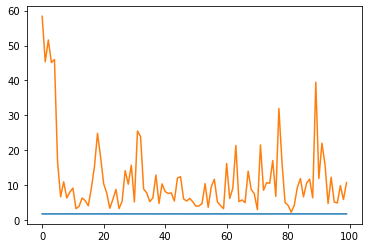

In [80]:
plt.plot(loss)
plt.plot(val_loss)

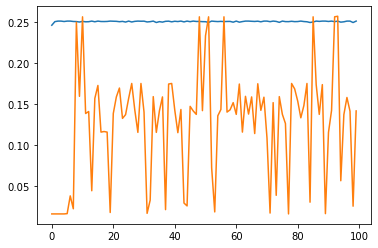

In [81]:
plt.plot(accuracy)
plt.plot(val_accuracy)

### make a prediction on a random image

In [82]:
single_image2 = cv2.imread('emotion_images/test/fear/PrivateTest_10153550.jpg',-1)
single_image3 = cv2.imread('emotion_images/test/happy/PrivateTest_10077120.jpg',-1)
single_image4 = cv2.imread('emotion_images/test/angry/PrivateTest_10131363.jpg',-1)

In [83]:
import matplotlib.pyplot as plt

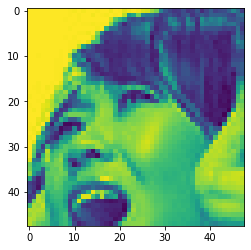

In [84]:
plt.imshow(single_image2)

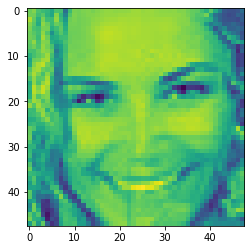

In [85]:
plt.imshow(single_image3)

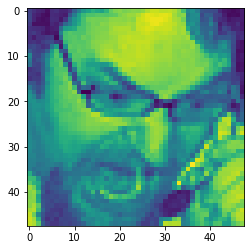

In [86]:
plt.imshow(single_image4)

In [87]:
single_image2 = np.expand_dims(single_image2, axis = 0)
single_image3 = np.expand_dims(single_image3, axis = 0)
single_image4 = np.expand_dims(single_image4, axis = 0)


single_image2 = np.expand_dims(single_image2, axis = -1)
single_image3 = np.expand_dims(single_image3, axis = -1)
single_image4 = np.expand_dims(single_image4, axis = -1)

In [88]:
single_image2.shape

(1, 48, 48, 1)

In [89]:
single_image2 = single_image2.astype('float16')
single_image3 = single_image3.astype('float16')
single_image4 = single_image4.astype('float16')

In [90]:
#predictions are angry, disgust, fear, happy, neutral, sad, surprise

In [95]:
#fear
model.predict(single_image2)

array([[1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [96]:
#happy
model.predict(single_image3)


array([[1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [97]:
#angry
model.predict(single_image4)


array([[1., 0., 0., 0., 0., 0., 0.]], dtype=float32)